# **Intro**
In this notebook I set up semi-supervised VAE that attempts to predict the digit from MNIST numbers.
In this vanilla semi-supervised VAE (ssVAE), we use the digits as labels.
We omit some labels so that it is semi-supervised.
Also, we use the M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning 
with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/






# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [ ]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [ ]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 16
-rw-r--r-- 1 root root  43 Aug  9 17:20 config
-rw------- 1 root root 432 Aug  9 17:20 id_rsa
-rw-r--r-- 1 root root 113 Aug  9 17:20 id_rsa.pub
-rw-r--r-- 1 root root 884 Aug  9 14:50 known_hosts


In [ ]:
%%bash
# do your git operations here
git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/ssvae_mnist.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


To github.com:nrosed/sc_bulk_ood.git
   fce02db..9763628  main -> main


# **Imports**

In [ ]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score



# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Import and Pre-process data**
Import + reshape the MNIST data

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

print(y_train[0:5])

(60000, 28, 28)
(10000, 28, 28)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# **Model Definition**

## Hyperparameters


In [ ]:
batch_size = 50
n_epoch = 5

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_train.shape[1]
n_y = y_train.shape[1]

print(f"length of X {n_x} and length of y {n_y}")



length of X 784 and length of y 10


## Encoder

In [ ]:
# declare the Keras tensor we will use as input to the encoder
_X = Input(batch_shape=(batch_size, n_x))
_Y = Input(batch_shape=(batch_size, n_y))

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(_X)

# now from the hidden layer, you get the mu and sigma for 
# the latent space
mu = Dense(n_z, activation='linear', name = "mu")(encoder_h)
l_sigma = Dense(n_z, activation='linear', name = "sigma")(encoder_h)



## Latent Space + Classifier

Classifier uses z to do prediction.
This is great when we have limited labeled data, because we can get a good representation to train the classifier on.

In [ ]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

def null_f(args):
    return args

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name="z_samp")([mu, l_sigma])
z_l = Lambda(null_f, output_shape = (n_z, ), name="z_null")(z)

#defining the architecture of the classifier
class_hidden1 = Dense(n_z, activation=activ, name = "cls_h1")
class_out = Dense(n_z, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(z_l)
_Y_cls = class_out(classifier_h1)


# again, this is kind of conditional, since we are using
# the classifier labels.... 
# we merge latent space with label or the predicted label
zc_labeled = concat([z, _Y])

zc_unlabeled = concat([z, _Y_cls])


## Decoder




In [ ]:
# set up decoder network
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")


# this is the LABELED decoder
d_h1_lab = decoder_hidden(z)
d_out_lab = decoder_out(d_h1_lab)


# this is the UNlabeled decoder
d_h1_unlab = decoder_hidden(z)
d_out_unlab = decoder_out(d_h1_unlab)


## Loss

In [ ]:
beta = 1
def labeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def unlabeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)

    return recon + kl

    # now make a for loop over all possible values of Y_labeled
    #recon = None
    #for idx in range(0, n_y):
    #  y_idx = to_categorical(idx)
    #  mu_idx, z_idx = encoder_unlab.predict([y_true, y_idx])
    #  decoder_idx = decoder_unlab.predict([z_idx, y_idx])

    # if recon == None:
    #   recon = K.sum(K.binary_crossentropy(y_true, decoder_idx), axis=-1)
    #  else:
    #    recon = recon + K.sum(K.binary_crossentropy(y_true, decoder_idx), axis=-1)

    # return recon / n_y + kl

def KL_loss(y_true, y_pred):
	return(beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def cls_loss(y_true, y_pred, N=1000):
    return K.categorical_crossentropy(y_true, y_pred)*1000


## Make the computational graph

In [ ]:
ss_vae_lab = Model([_X, _Y], [d_out_lab, _Y_cls])

encoder_lab = Model(_X, [mu, z])

ss_vae_unlab = Model(_X, d_out_unlab)

classifier = Model(_X, _Y_cls)

ss_vae_lab.compile(optimizer=optim, loss=[labeled_vae_loss, cls_loss]) #, metrics = [KL_loss, recon_loss])
ss_vae_unlab.compile(optimizer=optim, loss=unlabeled_vae_loss) #, metrics = [KL_loss, recon_loss])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


print(ss_vae_lab.summary())
print(ss_vae_unlab.summary())

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(50, 784)]          0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (50, 512)            401920      input_25[0][0]                   
__________________________________________________________________________________________________
mu (Dense)                      (50, 10)             5130        encoder_1[0][0]                  
__________________________________________________________________________________________________
sigma (Dense)                   (50, 10)             5130        encoder_1[0][0]                  
___________________________________________________________________________________________

# **Training**

Here we train using both the labeled and unlabeled data. 
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [ ]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    assert len(X_unlabeled) % len(X_labeled) == 0, \
            (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = ss_vae_lab.train_on_batch([X_labeled[index_range], y_labeled[index_range]], 
                                                [X_labeled[index_range], y_labeled[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [ss_vae_unlab.train_on_batch(X_unlabeled[index_range],  X_unlabeled[index_range])]
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# Experiments

Now lets train and evaluate the model.
First we train with 50 labeled and 50 unlabeled samples.
We will then increase the number of unlabeled samples from 50 to 5000.
We assume that increasing the number of unlabeled samples should result in an increase in accuracy, even though the number of labeled samples is constant.

Fitting with sample_size: 50



Elapsed:  11.07180404663086
 * Accuracy: 77.6 %
 * Fit time elapsed: 11.7s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,100.000000,100.000000,100.000000,100.000000
mean,149.729987,133.658363,16.071624,128.344801
std,94.445397,26.041045,82.850760,21.665287
min,114.243416,111.499939,2.296250,109.362541
0%,114.243416,111.499939,2.296250,109.362541
25%,119.887760,116.748852,3.092406,114.121483
50%,127.196606,123.779320,3.591583,120.932503
75%,141.623840,137.398952,4.528616,132.544353
95%,226.061365,197.853716,13.968267,186.464951
99%,432.413814,213.489580,235.274728,197.557316


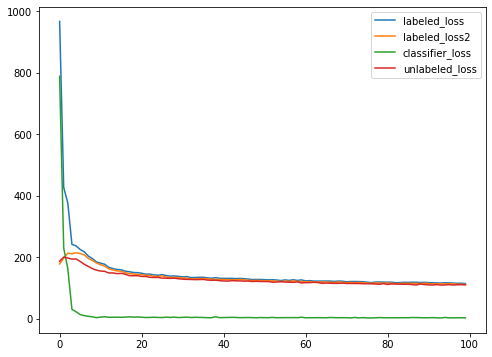

In [ ]:
sample_size = 50
num_unlabeled = 50
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=100)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Now lets train with 500 labeled and 5000 unlabeled samples.
We expect improvement in performance, since the representation of the samples (z) should be more accurate.*italicized text*

Fitting with sample_size: 50



Elapsed:  1.9807732105255127
 * Accuracy: 79.3 %
 * Fit time elapsed: 2.6s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,50.000000,50.000000,50.000000,50.000000
mean,176.327332,139.069984,37.257349,156.400905
std,158.945681,20.706145,155.151640,12.207733
min,121.297874,118.630470,2.052085,138.986435
0%,121.297874,118.630470,2.052085,138.986435
25%,126.642958,123.012148,2.896600,146.606468
50%,135.202240,130.610245,3.418764,152.714302
75%,155.799950,149.217129,4.209376,163.251553
95%,301.245779,183.240496,129.313905,181.343592
99%,864.516096,186.139473,717.467846,185.433703


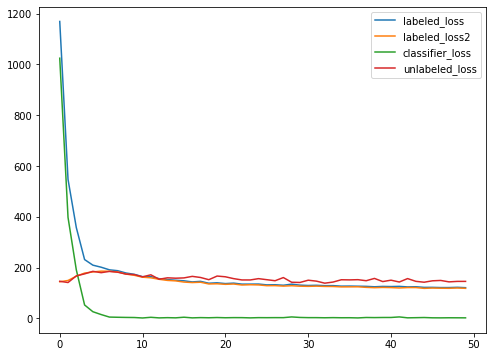

In [ ]:
sample_size = 50
num_unlabeled = 500
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Now lets train with 500 labeled and 50000 unlabeled samples.
We expect *more* improvement in performance, since the representation of the samples (z) should be more accurate.
The more data we use (even though it is unlabeled) should improve the end classifier.

Fitting with sample_size: 50



Elapsed:  15.564371824264526
 * Accuracy: 76.3 %
 * Fit time elapsed: 16.2s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,500.000000,500.000000,500.000000,500.000000
mean,110.765367,105.302851,5.462516,148.642048
std,44.318995,16.943061,34.684907,9.826424
min,94.891685,92.859840,1.393415,130.376144
0%,94.891685,92.859840,1.393415,130.376144
25%,98.889900,96.495298,2.228986,142.799324
50%,102.402168,99.951797,2.604286,147.108376
75%,109.521645,106.662992,3.199319,151.816402
95%,135.879434,132.426952,4.151422,163.364233
99%,216.240003,194.584787,14.501235,190.017027


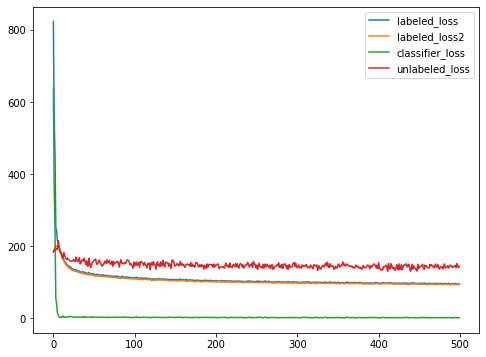

In [ ]:
sample_size = 50
num_unlabeled = 5000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

# **Baseline Model**

To ensure that we are beating the baseline model, lets use the same amount if labeled data to see that we will not perform as well.

In [ ]:
# baseline classifier

# normalizing the data to make the neural ntwork easier to learn
x_train = normalize(X_train, axis=1)
x_test = normalize(X_test, axis=1)

#choosing the sequential model
baseline_model = Sequential()

# defining the architecture of the model
# this has a similar number of parameters 
# but is still a good comparator
X_class = Input(shape=(n_x,))
baseline_model.add(X_class)
baseline_model.add(Dense(512, activation='relu'))
baseline_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
baseline_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

sample_size = 50
rand_idx = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]

#training the model
baseline_model.fit(X_train_subset, y_train_subset, epochs=n_epoch)

# get accuracy
y_pred = np.argmax(baseline_model.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

print(' * Accuracy: %.1f %%' % (100. * score))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_45 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples
Epoch 1/5
50/50 [==============================] - 0s 3ms/sample - loss: 2.3125 - accuracy: 0.0400
Epoch 2/5
50/50 [==============================] - 0s 318us/sample - loss: 1.6646 - accuracy: 0.6200
Epoch 3/5
50/50 [==============================] - 0s 252us/sample - loss: 1.2831 - accuracy: 0.7000
Epoch 4/5
50/50 [==============================] - 0s 337us/sample - loss: 0.9486 - accuracy: 0.8800
Epoch 5/5
50/50 [==============================] - 0s 401us/sample - loss: 0.7107 - acc